#**The YOLO book recommender**

The idea for this project was to get personalised book recommendations by taking a picture of your book shelf, or any bookshelves that sparks your interest. The network recognises the books on your bookshelf, and suggests some additional books you may like. 



**High level functionality:**



*   model_init() initialises the YOLO model, v3 in this example.
*   crop_books() passes the image through the model to detect the individual books and crop them. 
*   extract_books() extracts the text from each of the books using pytesseract and uses isbntools to collect the books meta data
*   google_recommender() finds similar books through the Google Books API.
*   print_recommendations() does what is says. 

The functions and implementation on my bookshelf can be seen below. Following that, the crop_books() and extract_books() functions are run with visualise=True, which gives a visual representation of the bounding boxes, cropped images and recognised text. 


# Imports

In [ ]:
# !pip install isbntools
# !sudo apt install tesseract-ocr
# !pip install pytesseract
# !pip install isbntools
# !pip install progress

from google.colab import drive
drive.mount('/content/gdrive/')

import os
import time
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import pytesseract
from pytesseract import Output

import requests
import urllib.request
from progress.bar import Bar

from isbntools.app import isbn_from_words
from isbntools.app import meta as isbn_meta

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To wrap long strings on new lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Functions

In [ ]:
# ----- FUNCTIONS

# YOLO Model & Class List
def model_init(config, weights, class_names, input_size=(412,412), input_scale=(1.0/255), swapRB=True):
    '''
    Args:
        config, weights, class_names: path to files
        input_size: for resizing of image before prediction
        input_scale: for rescaling of image before prediction
        swapRB: RGB -> BGR for openCV channel ordering

    Returns:
        model, classes
    '''

    print('Loading model...', end=' ')
    model = cv.dnn_DetectionModel(config, weights)
    model.setInputSize(input_size)
    model.setInputScale(input_scale)
    model.setInputSwapRB(swapRB)

    with open(class_names, 'rt') as f:
        class_names = f.read().rstrip('\n').split('\n')
    print('DONE', end='\n\n')

    return model, class_names


# Crop Books
def crop_books(model, image, confidence=0.2, NMS_threshold=0.4, visualise=False):
    '''
    Args:
        model: YOLO model
        image: path to input image
        confidence: minimum confidence of bbox predictions
        NMS_threshold: Non-maximum supression threshold
        visualise: used to visualise the YOLO process. if True, print out the image with bounsing boxes shown and one example of a cropped book. 

    Returns:
        cropped: A list of numpy array images of cropped book spines
    '''
    print('Cropping ROIs from image...', end=' ')
    cropped = []
    img = cv.imread(image)
    if visualise: img_visualise = cv.imread(image)

    # detecting books with YOLOv3
    classes, confs, boxes = model.detect(img, confThreshold=confidence, nmsThreshold=NMS_threshold)
    for class_i, conf, box in zip(classes.flatten(), confs.flatten(), boxes):
        x1, y1, w, h = box
        try: 
            crop = img[y1:y1+h, x1:x1+w]
            cropped.append([crop])
        except IndexError: pass # bounding boxes out of frame
        
        # drawing bounding boxes
        if visualise: cv.rectangle(img_visualise, (x1, y1), (x1 + w, y1 + h), (255, 0, 0), 5)

    print('DONE', end='\n\n')

    # Show bounding boxes and an example of a cropped book
    if visualise: 
        fig, (bbox_plt, crop_plt) = plt.subplots(1,2, figsize=(20,10))
        bbox_plt.imshow(img_visualise)
        crop_plt.imshow(cv.rotate(cropped[0][0], cv.ROTATE_90_COUNTERCLOCKWISE))
    
    return np.array(cropped).flatten()


# Extract Text
def extract_books(images, swapRB=True, visualise=False):
    '''
    ISBNS, meta = extract_books(images, swapRB)
    
    Args:
        images: list of cropped images
        swapRB: swap back from BGR -> RGB
        visualise: if True, show bounding boxes and predicted text

    Returns:
        ISBNs: list of ISBN numbers for detected books
        metas: list of book metadata
        authors: list of detected authors
    '''

    texts = []
    ISBNs = []
    metas = []
    # Read text
    print('Processing books...', end=' ')
    for i, image in enumerate(images):
        if swapRB:
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        OCR_data = pytesseract.image_to_data(image, output_type=Output.DICT)
        if visualise and i == 0: 
            img_visualise = cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)
            data_visualise = pytesseract.image_to_data(img_visualise, output_type=Output.DICT)
        text = OCR_data['text']
        while '' in text: text.remove('')
        text = ' '.join(text).lower()
        if len(text) > 1:
            texts.append(text)   
            # Get ISBNs & meta
            ISBNs.append(isbn_from_words(text))
            metas.append(isbn_meta(isbn_from_words(text)))

    authors = []
    for meta in metas:
        try: author = ', '.join(meta['Authors'])
        except KeyError: # when author missing
            author = 0
            pass
        if author:
            authors.append(author)
    print('DONE', end='\n\n')

    # show bounding boxes and predicted text
    if visualise:
        n_boxes = len(data_visualise['level'])
        for i in range(n_boxes):
            (x, y, w, h) = (data_visualise['left'][i], data_visualise['top'][i], 
                            data_visualise['width'][i], data_visualise['height'][i])
            text = data_visualise['text'][i]
            cv.rectangle(img_visualise, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv.putText(img_visualise, text, (x, y),
                        cv.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 3)
            cv.putText(img_visualise, text, (x, y),
                        cv.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        plt.figure(figsize=(20,10))
        plt.imshow(img_visualise)

        print('Book detected: {}'.format(' '.join(data_visualise['text'])))

    return ISBNs, metas, authors


# Search Google Books API for similar books
def google_recommender(authors):
    '''
    recommendations = search_google(authors)
    
    Args:
        authors: list of extracted authors, from extract_books function

    Returns:
        recommendations: list of recommendations in format: [[title, author, desc], ...]
    '''
    recommendations = []
    google_API = "https://www.googleapis.com/books/v1/volumes"
    
    print('Looking for recommendations...', end=' ')
    for author in authors:
        params = {"q": author, "maxResults": 10, 
          'startIndex': 5} # skip first few to get new books, other than search
        response = requests.get(google_API, params=params).json()
        try: 
            for book in response["items"]:
                volume = book["volumeInfo"]
                title = volume["title"]
                authors = ', '.join(volume["authors"])
                description = volume["description"]
                working = 1
                recommendations.append([title, authors, description])

        except KeyError: # missing info 
            pass

    print('DONE')    
    np.random.shuffle(recommendations)
    
    return recommendations # top 10 results search with author, return [title, author, desc]


# Print out recommendations 
def print_recommendations(recommendations, num=10, with_desc=True):
    '''
    print_recommendations(recommendations, num=10, with_desc=True)
    
    Args:
        recommendations: list of recommendations in format: [[title, author, desc], ...]
        num: number of recommendations to print, default=10
        with_desc: to print with description or not, default=True

    Returns nothing. Prints recommendations to screen. 
    '''
    if num > len(recommendations):
        raise Exception("'num' paramter too high, there are {} total recommendations available")

    np.random.shuffle(recommendations)
    print(f'\nHere are {num} recommendations based on your bookshelf:')
    for i, recommendation in enumerate(recommendations):
        if i >= num: break
        title = recommendation[0]
        authors = recommendation[1]
        desc = recommendation[2]

        print(f"\n\033[1m{i+1}. " + title + "\033[0m", end= '') # bold title
        print(f" - {authors}")
        if with_desc:
            print('\n' + desc)
            print('_'*100)

# Implementation

In [ ]:
# ----- PATHS
base_dir = '/content/gdrive/MyDrive/Colab Notebooks/book_project/'
img = base_dir + 'images/3_books.jpg'
coco_names = base_dir + 'yolo_data/coco.names'
config = base_dir + 'yolo_data/yolov3.cfg'
weights = base_dir + 'yolo_data/yolov3.weights'

# ----- FUNCTION CALLS
model, class_names = model_init(config, weights, coco_names)
cropped = crop_books(model, img)
ISBNs, meta, authors = extract_books(cropped)
recommendations = google_recommender(authors)

Loading model... DONE

Cropping ROIs from image... DONE

Processing books... DONE

Looking for recommendations... DONE


In [ ]:
# ----- PRINTING 10 RECOMMENDATIONS with_desc=False
print_recommendations(recommendations, num=10, with_desc=False)


Here are 10 recommendations based on your bookshelf:

1. Origins of Biodiversity - Lindell Bromham, Marcel Cardillo

2. The Original Hitchhiker Radio Scripts - Douglas Adams

3. Last Chance To See - Douglas Adams, Mark Carwardine

4. The Information - James Gleick

5. "What Do You Care What Other People Think?": Further Adventures of a Curious Character - Richard P. Feynman

6. A Qui Si! - M. Victoria Garcia Serrano, Annette Grant Cash, Cristina de la Torre

7. Gender, Peace and Security - Louise Olsson, Theodora-Ismene Gizelis

8. The Salmon of Doubt - Douglas Adams

9. Time Reborn - Lee Smolin

10. Pathfinders - Jim Al-Khalili


In [ ]:
# ----- PRINTING 2 RECOMMENDATIONS with_desc=True
print_recommendations(recommendations, num=2, with_desc=True)


Here are 2 recommendations based on your bookshelf:

1. Last Chance To See - Douglas Adams, Mark Carwardine

‘Descriptive writing of a high order... this is an extremely intelligent book’ The Times Join Douglas Adams, bestselling and beloved author of The Hitchhiker’s Guide to the Galaxy, and zoologist Mark Carwardine on an adventure in search of the world’s most endangered and exotic creatures. In this book, Adams’ self-proclaimed favourite of his own works, the pair encounter animals in imminent peril: the giant Komodo dragon of Indonesia, the lovable kakapo of New Zealand, the blind river dolphins of China, the white rhinos of Zaire, the rare birds of Mauritius island in the Indian Ocean and the alien-like aye-aye of Madagascar. Inimitably witty and poignant, Last Chance to See is both a celebration of our most extraordinary creatures and a warning about what we have to lose if we do not act soon. Featuring a fantastic new foreword by the authors' long-time friend Stephen Fry, and 

# Visualisation

# crop_books() function

**left image:** detected bounding boxes from the YOLOv3 model

**right image:** an example of one of the cropped images

Cropping ROIs from image... DONE



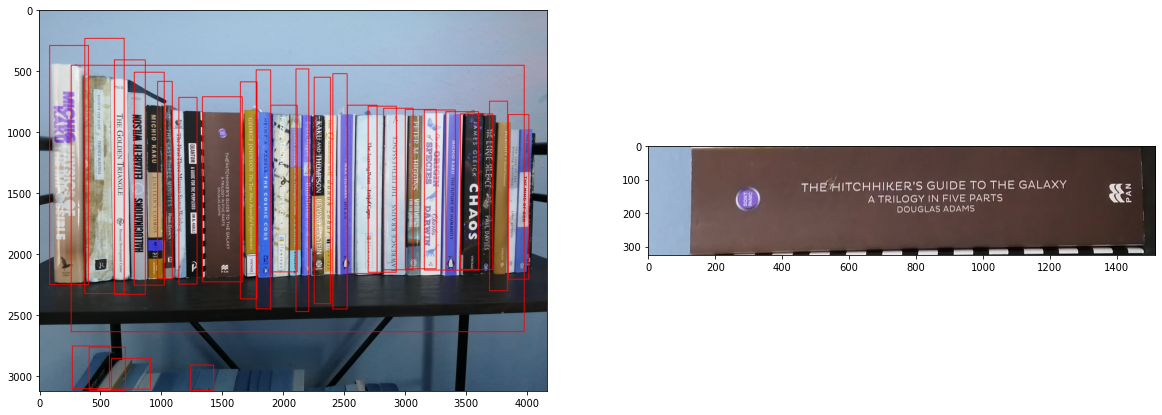

In [ ]:
cropped = crop_books(model, img, visualise=True)

# extract_books() function

Processing books... DONE

Book detected:          THEHITCHHIKER'S GUIDE TO THE GALAXY  A TRILOGY IN FIVE PARTS  DOUGLAS ADAMS


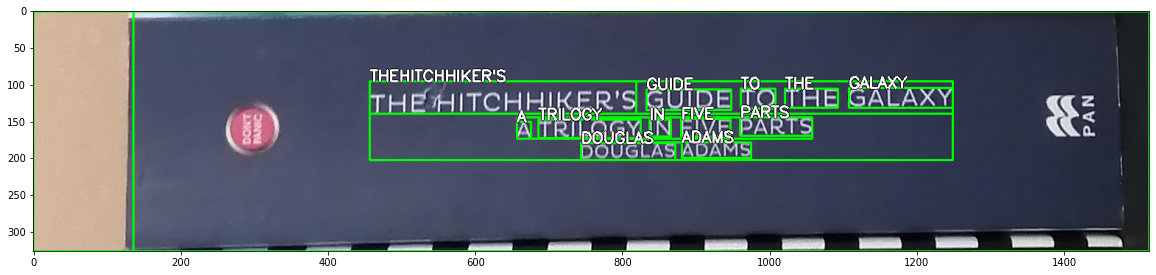

In [ ]:
ISBNs, metas, authors = extract_books(cropped, visualise=True)

# Future Work



*   The google_recommender() function searches similar books for each detected author and then shuffles them all together. Another method where books are cross referenced and recommendations are based on a combination of books would be an interesting project. 
*   The model is a bit slow, largely due to the yolov3 model. Using the yolov3-tiny, or a model made specifically for detecting book spines could be investigated. 
*   I will work on integrating this into a web application one day. 

